In [1]:
%matplotlib inline
 
import gzip
import pickle
from urllib.request import urlretrieve
import zipfile
 
import nengo
import numpy as np
import matplotlib.pyplot as plt
from nengo.dists import Choice
from nengo.utils.ensemble import tuning_curves
from nengo.utils.matplotlib import rasterplot
 
# urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open("mnist.pkl.gz") as f:
    train_data, _, test_data = pickle.load(f, encoding="latin1")
train_data = list(train_data)
test_data = list(test_data)

In [2]:
data = train_data
print(data[0].shape)#  784개의 값을 가지는 array 50000개
print(data[0].shape[0])

(50000, 784)
50000


In [3]:
one_hot = np.zeros((data[0].shape[0], 10)) # one_hot.shpae = (50000, 10) --> 10개의 데이터 값을 가지는 array 50000개가 0으로 초기화

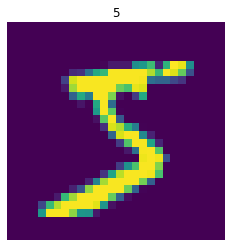

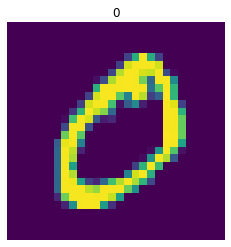

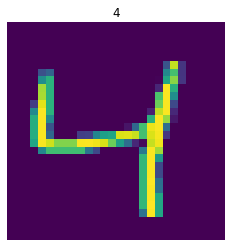

In [4]:
for data in (train_data, test_data):
    one_hot = np.zeros((data[0].shape[0], 10))
    one_hot[np.arange(data[0].shape[0]), data[1]] = 1
    data[1] = one_hot
 
for i in range(3):
    plt.figure()
    plt.imshow(np.reshape(train_data[0][i], (28, 28)))
    plt.axis('off')
    plt.title(str(np.argmax(train_data[1][i])));

In [5]:
def image_input(t):
    img = train_data[0][int(t/10)]
    return img

In [6]:
model = nengo.Network()

neuron_number = 28 * 28

with model:
    input_node = nengo.Node(image_input)
    pre_neuron = nengo.Ensemble(neuron_number, dimensions=neuron_number)
    nengo.Connection(input_node, pre_neuron)
             
    input_p = nengo.Probe(input_node)
    pre_p = nengo.Probe(pre_neuron.neurons, 'voltage')
    pre_spike_p = nengo.Probe(pre_neuron.neurons)


In [7]:
with nengo.Simulator(model) as sim:
    sim.run(30)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<AxesSubplot:>

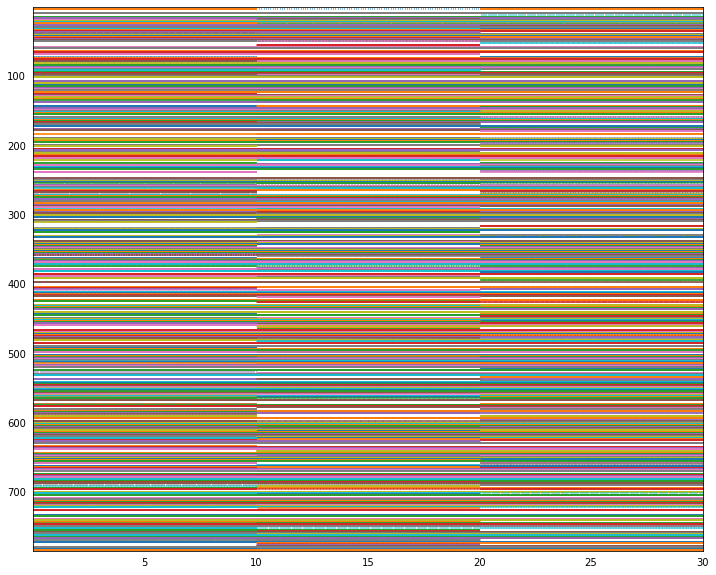

In [8]:
plt.figure(figsize=(12, 10))
rasterplot(sim.trange(), sim.data[pre_spike_p])

In [9]:
def label_input(t):
    label = train_data[1][int(t/10)]
    return label

In [10]:
N = 10 # number of neurons
D_inp = 28*28   # input size
D_out = 10  # label size
model = nengo.Network('MNIST Classification')
weights = np.random.randn(D_inp,D_out).transpose()  

In [11]:
with model:       
    #Define network inputs
    stim = nengo.Node(output=image_input, size_out=D_inp)
    stim_ans = nengo.Node(output=label_input, size_out=D_out)
    
    #Create neural ensembles
    input = nengo.Ensemble(N*D_inp, dimensions=D_inp, label="input") 
    answer = nengo.Ensemble(N*D_out, dimensions=D_out, label="answer")
    correct_answer = nengo.Ensemble(N*D_out, dimensions=D_out, label="correct_answer") 
    
    #Provide inputs to the network
    nengo.Connection(stim, input) 
    nengo.Connection(stim_ans, correct_answer)
    
    #Compute error for learning
    error = nengo.Ensemble(N*D_out, dimensions=D_out, label="error")  
    nengo.Connection(answer, error, transform=1)
    nengo.Connection(correct_answer, error, transform=-1)
    
    conn = nengo.Connection(input, answer, transform=weights)
    conn.learning_rule_type = nengo.PES(1e-4)

    nengo.Connection(error, conn.learning_rule)  

In [12]:
with model:
    input_p = nengo.Probe(input, synapse=0.1)
    answer_p = nengo.Probe(answer, synapse=0.1)
    correct_answer_p = nengo.Probe(correct_answer, synapse=0.1)
    error_p = nengo.Probe(error, synapse=0.1) 

In [13]:
sim = nengo.Simulator(model)
sim.run(500)
t = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Text(0.5, 1.0, 'Error')

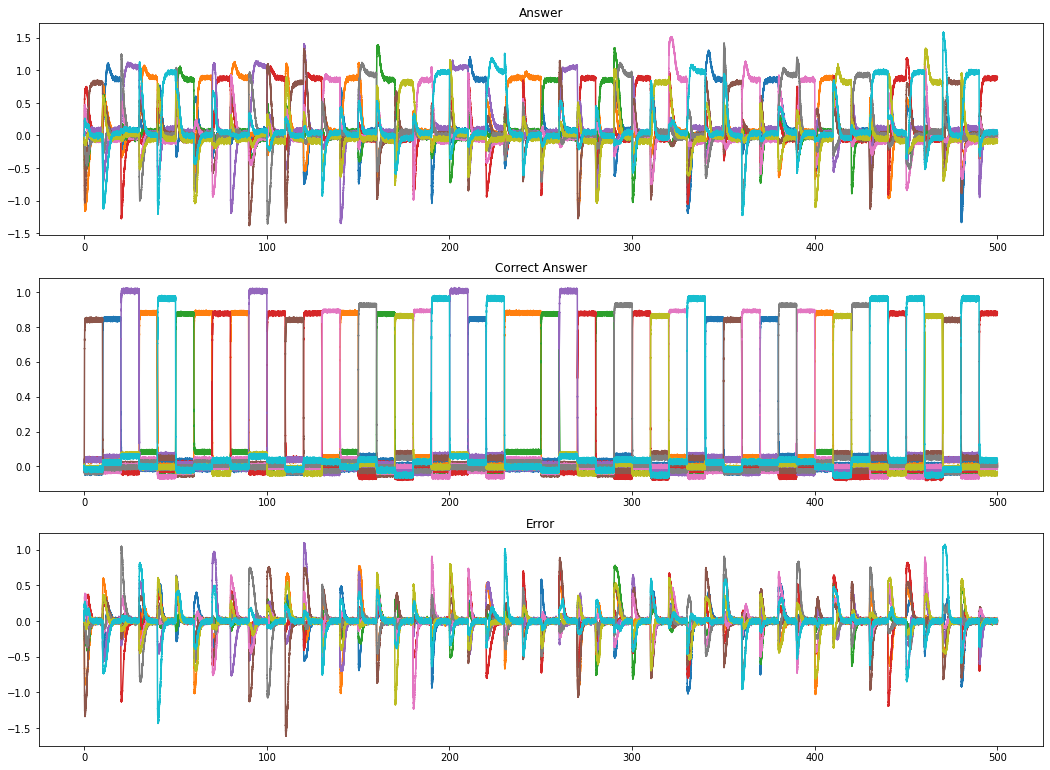

In [14]:
fig = plt.figure(figsize=(18,18))
p1 = fig.add_subplot(4,1,1)
p1.plot(t, sim.data[answer_p])
p1.set_title("Answer")

p2 = fig.add_subplot(4,1,2)
p2.plot(t, sim.data[correct_answer_p])
p2.set_title("Correct Answer")

p3 = fig.add_subplot(4,1,3)
p3.plot(t, sim.data[error_p])
p3.set_title("Error")
